In [95]:
# Load libraries

## -*- coding: utf-8 -*-
from utils import timeit 
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



#Titanic Data Cleaning

## Code courtsey: Manav Sehgal (https://www.kaggle.com/startupsci)
## Link to Original Code: https://www.kaggle.com/startupsci/titanic-data-science-solutions
# data analysis and wrangling

import pandas as pd
import numpy as np
import random as rnd

def titanic(train, test):
    train_df = pd.read_csv(train)
    test_df = pd.read_csv(test)
    combine = [train_df, test_df]

    train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
    test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

    pd.crosstab(train_df['Title'], train_df['Sex'])

    for dataset in combine:
        dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    for dataset in combine:
        dataset['Title'] = dataset['Title'].map(title_mapping)
        dataset['Title'] = dataset['Title'].fillna(0)

    train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
    test_df = test_df.drop(['Name'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

    guess_ages = np.zeros((2,3))
    guess_ages

    for dataset in combine:
        for i in range(0, 2):
            for j in range(0, 3):
                guess_df = dataset[(dataset['Sex'] == i) & \
                                      (dataset['Pclass'] == j+1)]['Age'].dropna()

                # age_mean = guess_df.mean()
                # age_std = guess_df.std()
                # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

                age_guess = guess_df.median()

                # Convert random age float to nearest .5 age
                guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

        for i in range(0, 2):
            for j in range(0, 3):
                dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                        'Age'] = guess_ages[i,j]

        dataset['Age'] = dataset['Age'].astype(int)

    for dataset in combine:
        dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1



    for dataset in combine:
        dataset['IsAlone'] = 0
        dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

    combine = [train_df, test_df]

    freq_port = train_df.Embarked.dropna().mode()[0]

    for dataset in combine:
        dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

    test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
    
    #Convert categorical variable into dummy variables
    train_df = pd.get_dummies(train_df)
    test_df  = pd.get_dummies(test_df)

    return (train_df, test_df)

In [96]:
train = 'train.csv'
test = 'test.csv'
titanic_train,titanic_test = titanic(train, test)

In [97]:
Y = titanic_train['Survived']

In [98]:
X = titanic_train.iloc[:,1:]

In [99]:
clf_RF = RandomForestClassifier(max_depth=5)
clf_RF = clf_RF.fit(X,Y)
Y_pred_random_forest = clf_RF.predict(titanic_test.iloc[:,1:])



In [100]:
df_random = pd.DataFrame(np.array([titanic_test.iloc[:,0],Y_pred_random_forest]).T,columns=['PassengerId','Survived'])  
df_random.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [101]:
df_random.to_csv('prediction_random_forest.csv',index=False)

In [102]:
@timeit
def grid_output(parameters,X,Y,clf):
    '''
    To get the Grid Object CV results
    '''
    num_test = 0.20
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = num_test,random_state = 23)
    acc_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
    grid_obj = grid_obj.fit(X_train, Y_train)    
    return grid_obj

In [103]:
@timeit
def plot_data(grid_obj):
    '''
    To plot the data with Estimator and Mean Scores
    '''
    test_score = grid_obj.cv_results_['mean_test_score']
    train_score = grid_obj.cv_results_['mean_train_score']
    labels = map(str, grid_obj.param_grid.values()[0])
    x = np.arange(1, len(labels)+1)
    sns.set_style('darkgrid')
    plt.figure(figsize=(10,6))
    plt.plot(x, test_score, c='purple')
    plt.plot(x, train_score, c='green')
    plt.xlabel(grid_obj.param_grid.keys()[0])
    plt.xticks(x, labels)
    plt.show()

In [104]:
clf = RandomForestClassifier(oob_score=True)


In [105]:
# parameters = {'n_estimators': [4, 6, 9], 
#               'max_features': ['log2', 'sqrt','auto'], 
#               'criterion': ['entropy', 'gini'],
#               'max_depth': [2, 3, 5, 10], 
#               'min_samples_split': [2, 3, 5],
#               'min_samples_leaf': [1,5,8]
#              }

parameters1 = {'n_estimators': [2,4,6,8,16,32]}
parameters2 = {'max_depth': [2, 3, 5, 10]}
parameters3 = {'min_samples_split': [2, 3, 5]}
parameters4 = {'max_features': ['log2', 'sqrt','auto']}
parameters5 = {'criterion': ['entropy', 'gini']}

'grid_output'  1700.31 ms


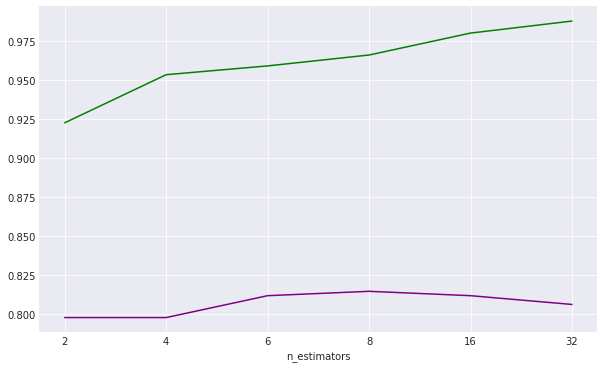

'plot_data'  364.19 ms


In [106]:
#Plot of N_estimators Variation

t1 = grid_output(parameters1,X,Y,clf)
plot_data(t1)

'grid_output'  1180.20 ms


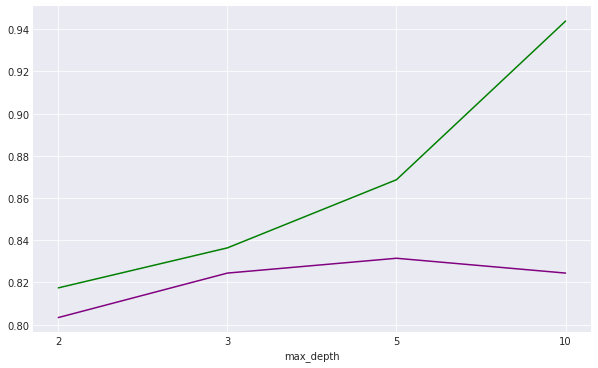

'plot_data'  350.75 ms


In [107]:
#Plot of max_depth Variation

t2 = grid_output(parameters2,X,Y,clf)
plot_data(t2)

'grid_output'  999.64 ms


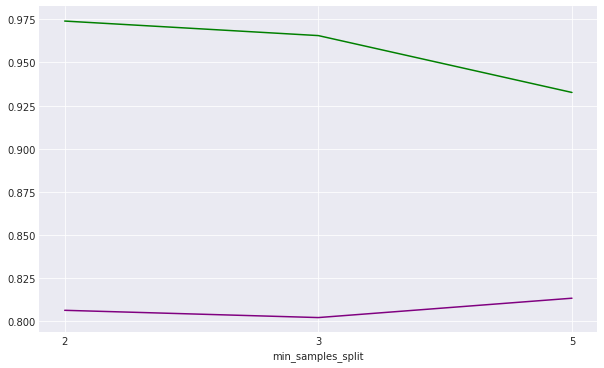

'plot_data'  403.13 ms


In [108]:
#Plot of min_samples_split Variation


t3 = grid_output(parameters3,X,Y,clf)
plot_data(t3)

'grid_output'  783.03 ms


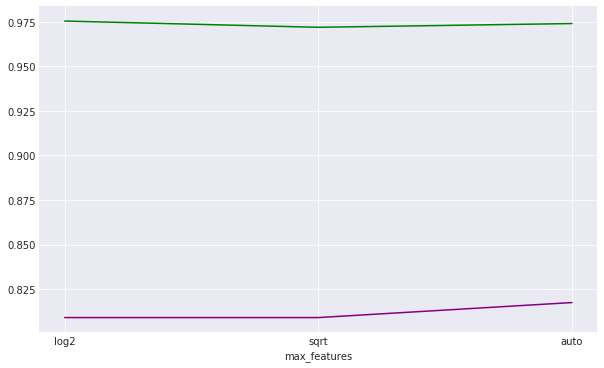

'plot_data'  323.48 ms


In [109]:
#Plot of max_features Variation

t4 = grid_output(parameters4,X,Y,clf)
plot_data(t4)

'grid_output'  631.95 ms


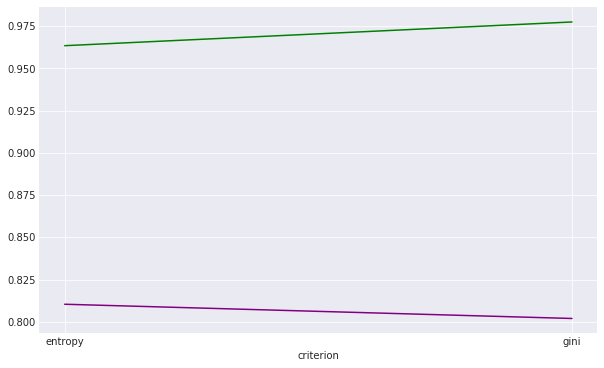

'plot_data'  330.37 ms


In [110]:
#Plot of criterion Variation

t5 = grid_output(parameters5,X,Y,clf)
plot_data(t5)